# 03 Barometric pressure lows statistical analysis

In [8]:
# Import libraries and functions
from datetime import date

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import xarray as xr
import pandas as pd
import numpy as np
import cmocean

from qartod_testing.local_qc_test import load_gross_range_qartod_test_values, load_climatology_qartod_test_values
from ooi_data_explorations.common import m2m_request, m2m_collect

In [2]:
# Set refdes and other data stream parameters
refdes = 'CP01CNSM-SBD11-06-METBKA000'
site, node, sensor = refdes.split('-',2)
method = 'recovered_host'
stream = 'metbk_hourly'

In [3]:
# Import async data request dict from text file saved in notebook 01
file = f"../data/external/{refdes}_{method}_{stream}_asyncm2m.txt"
with open(file) as f:
    data = eval(f.read())

In [4]:
# Load data from thredds catalog via M2M API
cnsm_metbk = m2m_collect(data, tag=('.*metbk_a_dcl_instrument_recovered.*\.nc$'))

In [5]:
# Create function to make plots with color from QARTOD flag result
def color_by_flag(ds, parameter, ax=None, fig=None):
    """ from dataset and parameter name string
    plot a timeseries of the named parameter and 
    color data points based on the corresponding QARTOD
    flag in the relevant _qartod_result parameter in
    the dataset.
    To-do: (maybe not if providing axes works better) 
    if parameter is a list-type, create subplots
    for each of the listed parameters
    Kylene M Cooley
    Version 6 Feb 2024
    
    Inputs:
    -------
    ds, xarray dataset
    parameter, string
    ax, optional matplotlib axes object
    fig, required if ax is provided
    
    Returns:
    --------
    fig, matplotlib figure object
    ax, matplotlib axes object
    """
    # Create data arrays to plot/color points
    da_plot = ds[parameter]
    da_color = ds[f"{parameter}_qartod_results"]
    
    # Create new axes object if none provided
    if not ax:
        fig, ax = plt.subplots(1, 1, figsize=(8,3), layout="tight")
        # Plot data points in scatter plot
        ax.scatter(da_plot['time'].where(da_color==1), da_plot.where(da_color==1), s=2, edgecolors='none',
                c='black', label="pass")
        ax.scatter(da_plot['time'].where(da_color==2), da_plot.where(da_color==2), s=2, edgecolors='none',
                c='gray', label="not evaluated")
        ax.scatter(da_plot['time'].where(da_color==3), da_plot.where(da_color==3), s=2, edgecolors='none',
                c='green', label="of interest")
        ax.scatter(da_plot['time'].where(da_color==4), da_plot.where(da_color==4), s=2, edgecolors='none',
                c='red', label="fail")
        plt.legend(markerscale=4)
        plt.grid()
    else:
        ax.scatter(da_plot['time'].where(da_color==1), da_plot.where(da_color==1), s=2, edgecolors='none',
                  c='black')
        ax.scatter(da_plot['time'].where(da_color==2), da_plot.where(da_color==2), s=2, edgecolors='none',
                c='gray')
        ax.scatter(da_plot['time'].where(da_color==3), da_plot.where(da_color==3), s=2, edgecolors='none',
                c='green')
        ax.scatter(da_plot['time'].where(da_color==4), da_plot.where(da_color==4), s=2, edgecolors='none',
                c='red')
        plt.grid()
    return fig, ax

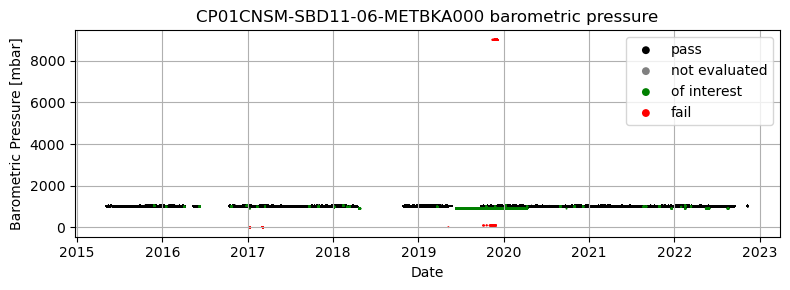

In [7]:
# Plot pressure at CNSM with color from qartod flag
fig, ax = color_by_flag(cnsm_metbk, "barometric_pressure")
plt.title("CP01CNSM-SBD11-06-METBKA000 barometric pressure")
plt.xlabel("Date")
plt.ylabel("Barometric Pressure [mbar]")
# ax.legend(loc="upper left", markerscale=4)
plt.show()

In [6]:
# Use cmocean package for same orange colors for suspect flags from bomb cyclone plot
cmdict = cmocean.tools.get_dict(cmocean.cm.matter, N=10) # we won't use first or last colors b/c not clearly orange
# print(cmdict["red"][1:4])

In [9]:
rgb = np.zeros([3, 3])
for idx, key in enumerate(cmdict.keys()):
    for j in range(1,4):
        rgb[idx, j-1] = cmdict[key][j][1]
rgb

array([[0.97928916, 0.95711389, 0.92044532],
       [0.77737806, 0.62693242, 0.47194958],
       [0.54875439, 0.43098874, 0.3461126 ]])

/home/jovyan/.conda/envs/pioneer_metbk/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


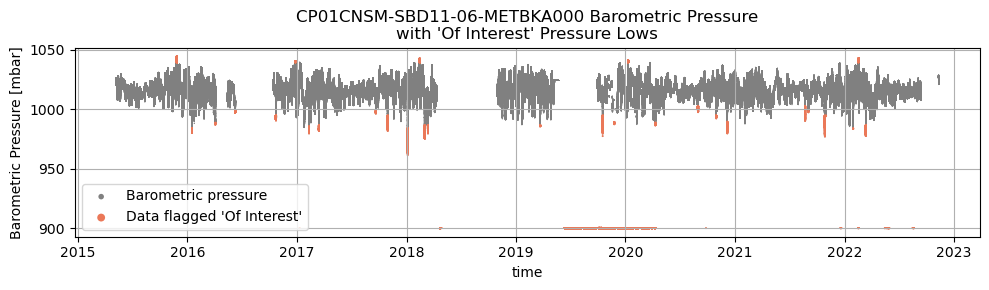

In [11]:
# Plot time series of barometric pressure at CNSM
fig, ax = plt.subplots(1, 1, figsize=(10, 3), layout="tight")
cnsm_metbk["barometric_pressure"].where(cnsm_metbk["barometric_pressure_qartod_results"]!=4).plot.scatter(s=1,
    ax=ax, c="gray", label="Barometric pressure", edgecolors="none")
cnsm_metbk["barometric_pressure"].where(cnsm_metbk["barometric_pressure_qartod_results"]==3).plot.scatter(s=2,
    ax=ax, color=rgb[:, 2], label="Data flagged 'Of Interest'", edgecolors="none")
plt.grid()
plt.legend(markerscale=4)
plt.title(f"{refdes} Barometric Pressure\nwith 'Of Interest' Pressure Lows")
plt.show()

In [12]:
fig.savefig("../data/processed/CNSM_baropress_ofinterest-3.png")

/tmp/ipykernel_2880/2984160479.py:1: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig("../data/processed/CNSM_baropress_ofinterest-3.png")
